Importar librerias

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import t

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Se define el valor de alfa

In [2]:
ALPHA = 0.002

In [3]:
Datos = pd.read_csv("AutomobileEnginePiston.csv")

In [4]:
DatosSinMuestra = Datos.drop('Muestra', axis=1)

Datos['MuestraNumero']   = DatosSinMuestra.count(axis=1)
Datos['MuestraMedia']    = DatosSinMuestra.mean(axis=1)
Datos['MuestraVarianza'] = DatosSinMuestra.var(axis=1)
Datos['MuestraDesvio']   = DatosSinMuestra.std(axis=1)

In [5]:
# lista en donde guardaremos los limites de control superior e inferior teoricos para la media muestral
UclTeoMediaMuestras, LclTeoMediaMuestras = [], [] 

# lista en donde guardaremos los limites de control superior e inferior empiricos para la media muestral (solo a manera de comparacion entre el resultado teorico y el muestral)
UclEmpMediaMuestras, LclEmpMediaMuestras = [], []

# lista en donde guardaremos los limites de control superior e inferior empiricos para el desvío muestral
UclEmpDesvioMuestras, LclEmpDesvioMuestras = [], []

Control estadístico de procesos bayesiano

Para los hiperparámetros se debe tomar:

kappa = 0

mu en los reales

nu = -1

sigma2 = 0

En la actualización de los parámetros se toma la idea de que la posterior de hoy es la previa de mañana y se usan los parametros definidos para la predictiva posterior



In [6]:
# inicializamos nuestros parámetros partiendo de una previa no informativa
kappa = 0
mu = 0
nu = -1
sigma2 = 0

M = 10**4 # numero de muestras a simular para la estimacion empirica de los limites de control

for i in range(len(Datos)):

    # para cada muestra actualizamos los parametros
    YBar = Datos.iloc[i]['MuestraMedia']
    n     = int(Datos.iloc[i]['MuestraNumero'])
    S2    = Datos.iloc[i]['MuestraVarianza']

    # actualizamos los parametros con cada nueva muestra
    kappa_new  = kappa + n
    mu_new     = (kappa/(kappa + n))*mu + (n/(kappa+n))*YBar
    nu_new     = nu + n

    #Para sigma tenemos que ver los grados de libertad. Deben ser mayores a 2.
    #definimos una primera parte de nu_new * sigma2_new
    componente = nu*sigma2 + ((kappa*n)/(kappa + n))*(YBar - mu)**2
    
    #completamos despejando sigma cuadrada y añadiendo el componente que definimos arriba
    if nu_new:
      sigma2_new = 1/nu_new * ((n-1)*S2 + componente)
    else:
      sigma2_new = 0

    kappa, mu, nu, sigma2 = kappa_new, mu_new, nu_new, sigma2_new

    if nu > 2:
      # calculamos los limites de control teoricos para la media del proceso
      UclTeoMediaMuestra = mu + np.sqrt(1/n) * t.ppf(1 - ALPHA/2, nu) * np.sqrt(nu/(nu-2)*(1+kappa)*sigma2/kappa)
      LclTeoMediaMuestra = mu - np.sqrt(1/n) * t.ppf(1 - ALPHA/2, nu) * np.sqrt(nu/(nu-2)*(1+kappa)*sigma2/kappa)
      # simulamos M muestras del mismo tamaño que la muestra observada
      YMuestra = t.rvs(size=n*M, df=nu, loc=mu, scale=np.sqrt((1 + kappa) / kappa * sigma2)).reshape(n, 10**4)

      # media empirica y desviacion empirica para la media del proceso
      YBarMuestra = np.mean(YMuestra, axis=0)
      YBarBar = YBarMuestra.mean()
      YBarStd = YBarMuestra.std()

      # calculamos los limites de control empiricos para la media del proceso
      UclEmpMediaMuestra = YBarBar + YBarStd * t.ppf(1-ALPHA/2, nu)
      LclEmpMediaMuestra = YBarBar - YBarStd * t.ppf(1-ALPHA/2, nu)    

      # media empirica y desviacion empirica para la desviacion del proceso
      SMuestra = np.std(YMuestra, axis=0)
      SBar = SMuestra.mean()
      SStd = SMuestra.std()

      # calculamos los limites de control empiricos para el desvio del proceso
      UclEmpDesvioMuestra = SBar + 3 * SStd
      LclEmpDesvioMuestra = max(SBar - 3 * SStd, 0)
    
    else:
      UclTeoMediaMuestra = np.nan
      UclEmpMediaMuestra = np.nan
      UclEmpDesvioMuestra = np.nan

      LclTeoMediaMuestra = np.nan
      LclEmpMediaMuestra = np.nan
      LclEmpDesvioMuestra = np.nan
    
    # agregamos los limites de control a nuestras listas
    UclTeoMediaMuestras.append(UclTeoMediaMuestra)
    LclTeoMediaMuestras.append(LclTeoMediaMuestra)

    UclEmpMediaMuestras.append(UclEmpMediaMuestra)
    LclEmpMediaMuestras.append(LclEmpMediaMuestra)

    UclEmpDesvioMuestras.append(UclEmpDesvioMuestra)
    LclEmpDesvioMuestras.append(LclEmpDesvioMuestra)

Agregamos los límites de control a los datos

In [7]:
Datos['UclTeoMediaMuestras'] = UclTeoMediaMuestras
Datos['LclTeoMediaMuestras'] = LclTeoMediaMuestras

Datos['UclEmpMediaMuestras'] = UclEmpMediaMuestras
Datos['LclEmpMediaMuestras'] = LclEmpMediaMuestras

Datos['UclEmpDesvioMuestras'] = UclEmpDesvioMuestras
Datos['LclEmpDesvioMuestras'] = LclEmpDesvioMuestras

Gráficos de Control

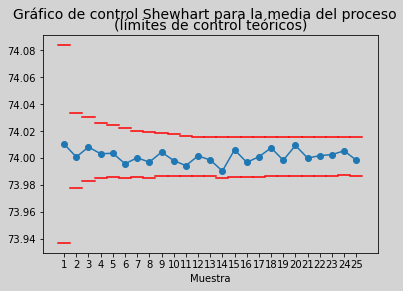

In [8]:
fig, ax = plt.subplots(facecolor='lightgrey')

plt.plot(Datos['Muestra'], Datos['MuestraMedia'], marker='o')

for i in Datos['Muestra']:

    plt.plot([i-0.5, i+0.5], [Datos.loc[Datos['Muestra']==i, 'UclTeoMediaMuestras'].values[0]]*2, color='r')
    plt.plot([i-0.5, i+0.5], [Datos.loc[Datos['Muestra']==i, 'LclTeoMediaMuestras'].values[0]]*2, color='r')

plt.suptitle("Gráfico de control Shewhart para la media del proceso", fontsize=14)
plt.title("(límites de control teóricos)", fontsize=14)

plt.xlabel('Muestra')
ax.set_xticks(Datos['Muestra'])
ax.set_facecolor('lightgrey')

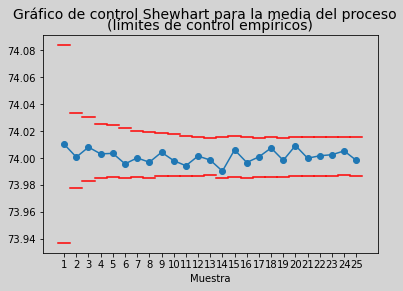

In [9]:
fig, ax = plt.subplots(facecolor='lightgrey')

plt.plot(Datos['Muestra'], Datos['MuestraMedia'], marker='o')

for i in Datos['Muestra']:

    plt.plot([i-0.5, i+0.5], [Datos.loc[Datos['Muestra']==i, 'UclEmpMediaMuestras'].values[0]]*2, color='r')
    plt.plot([i-0.5, i+0.5], [Datos.loc[Datos['Muestra']==i, 'LclEmpMediaMuestras'].values[0]]*2, color='r')

plt.suptitle("Gráfico de control Shewhart para la media del proceso", fontsize=14)
plt.title("(límites de control empíricos)", fontsize=14)

plt.xlabel('Muestra')
ax.set_xticks(Datos['Muestra'])
ax.set_facecolor('lightgrey')

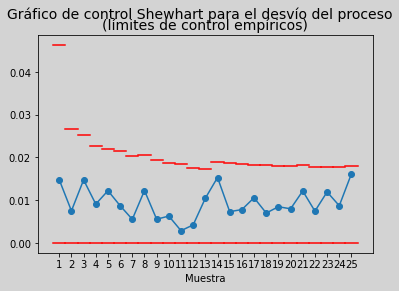

In [10]:
fig, ax = plt.subplots(facecolor='lightgrey')

plt.plot(Datos['Muestra'], Datos['MuestraDesvio'], marker='o')

for i in Datos['Muestra']:

    plt.plot([i-0.5, i+0.5], [Datos.loc[Datos['Muestra']==i, 'UclEmpDesvioMuestras'].values[0]]*2, color='r')
    plt.plot([i-0.5, i+0.5], [Datos.loc[Datos['Muestra']==i, 'LclEmpDesvioMuestras'].values[0]]*2, color='r')

plt.suptitle("Gráfico de control Shewhart para el desvío del proceso", fontsize=14)
plt.title("(límites de control empíricos)", fontsize=14)

plt.xlabel('Muestra')
ax.set_xticks(Datos['Muestra'])
ax.set_facecolor('lightgrey')